In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

In [2]:
# Read the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Functions for voxel reps and pointcloud reps
def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]

def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

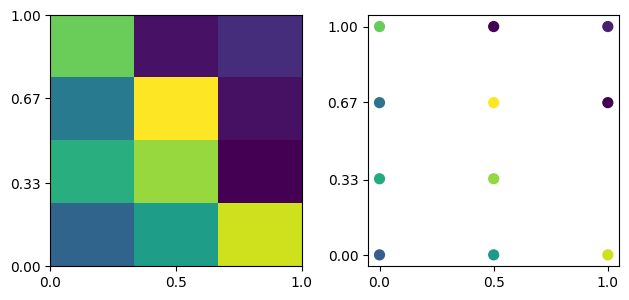

In [4]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

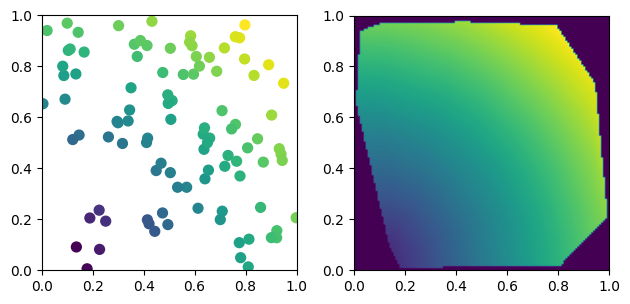

In [5]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [6]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

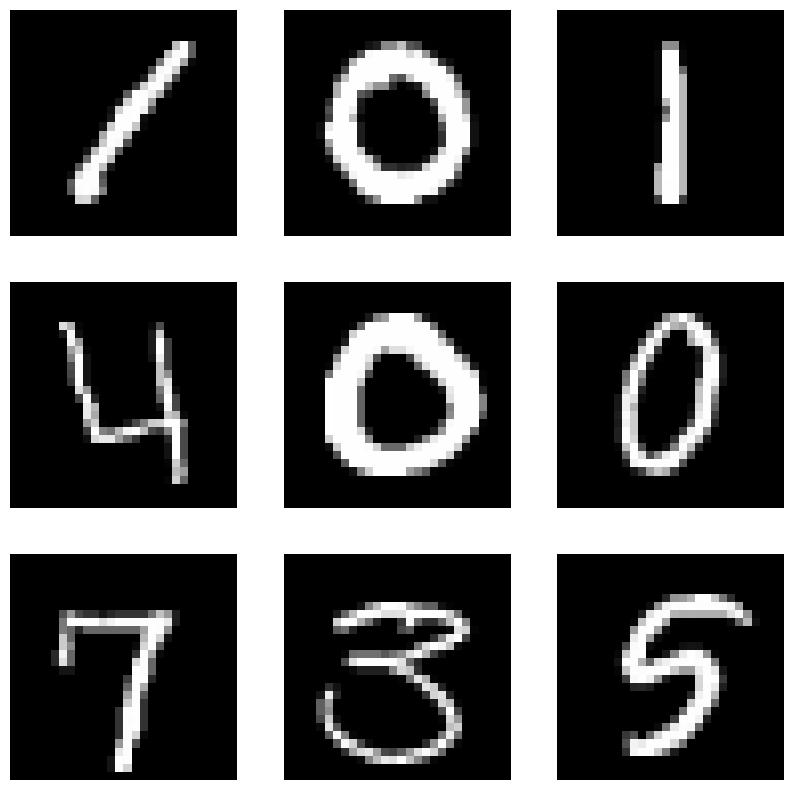

In [7]:
train_X = train_data.drop("label", axis=1).values
train_y = train_data['label'].values

test_X = test_data.values

img_rows, img_cols = 28, 28

train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols)
test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols)

# Create subplots
fig, plts = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        plts[i, j].imshow(train_X[idx], cmap=plt.get_cmap('gray'))
        plts[i, j].axis('off')  # Turn off axis
plt.show()


In [8]:
# Extract 0s
zeros = train_X[train_y==0]
zeros.shape

ones = train_X[train_y==1]

twos = train_X[train_y==2]

threes = train_X[train_y==3]

fours = train_X[train_y==4]

fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

In [9]:
print(zeros.shape)

(4132, 28, 28)


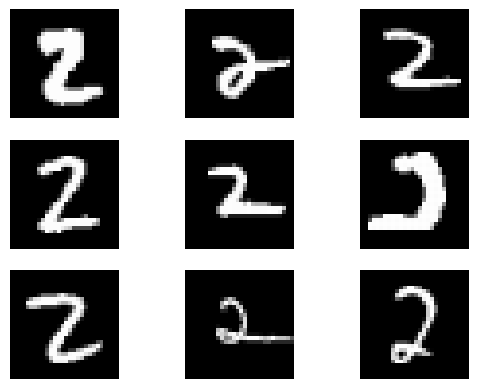

In [10]:
fig,plts = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        plts[i,j].imshow(twos[i + 3*j], cmap=plt.get_cmap('gray'))
        plts[i,j].axis('off')

grid shape (2, 28, 28)


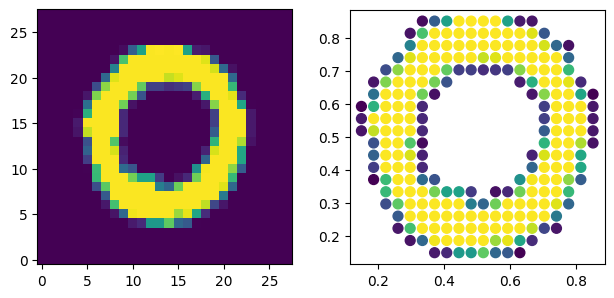

In [11]:
## Test creating pointclouds from MNIST zeros
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = zeros[0,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

grid shape (2, 28, 28)


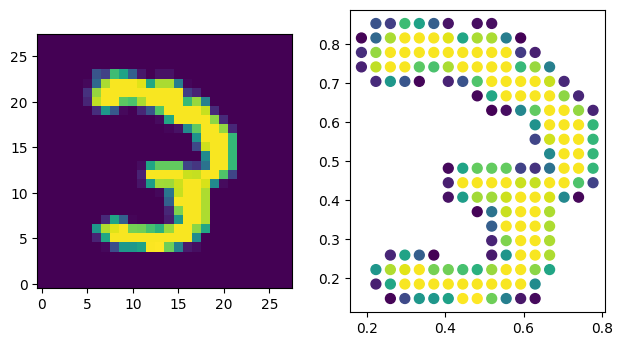

In [12]:
## Test creating pointclouds from MNIST threes
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = threes[1,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

grid shape (2, 28, 28)


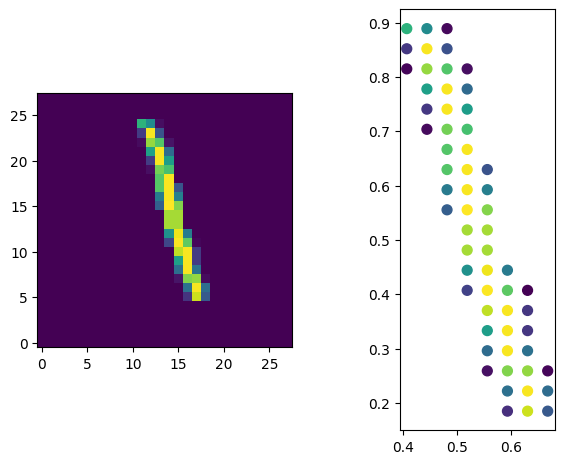

In [13]:
## Test creating pointclouds from MNIST ones
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = ones[3,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

In [48]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.values

n_samples = 1000
X_subset = X_train[:n_samples]
y_subset = y_train[:n_samples]

In [49]:
grid_x, grid_y = np.meshgrid(np.arange(28), np.arange(28))
grid = np.stack((grid_x, grid_y))

reshaped_images = X_subset.reshape(-1, 28, 28)
pointclouds = []
for image in reshaped_images:
    pointcloud = vox_to_pointcloud(image, grid)
    pointclouds.append(pointcloud)

### Wassmap embeddings 

In [50]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [51]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

In [52]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

/tmp/ipykernel_1670384/2814872471.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,0] = xx[i]
/tmp/ipykernel_1670384/2814872471.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,1] = yy[i]


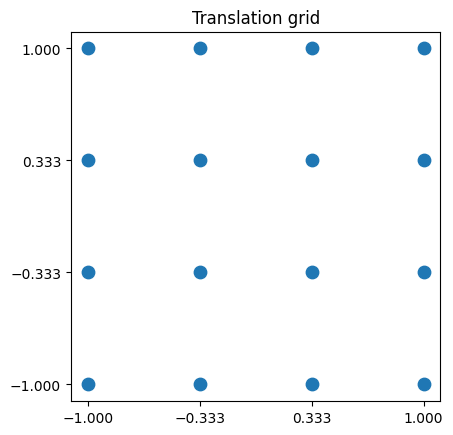

In [53]:
##Circle translate test 1:OVERLAPPING IMAGES::Image generation and setup
# NOTE: In this test, the translation grid is such that the resulting synthetic
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]

# Plot the translation set
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=80)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_paramset.pdf',bbox_inches='tight')

# Generate translation images and image tensor
trans_images = []
for image in reshaped_images:
    pointcloud = vox_to_pointcloud(image, grid)
    trans_images.append(pointcloud)


Computed Wasserstein distance matrix (N = 16) in 800.3949 seconds


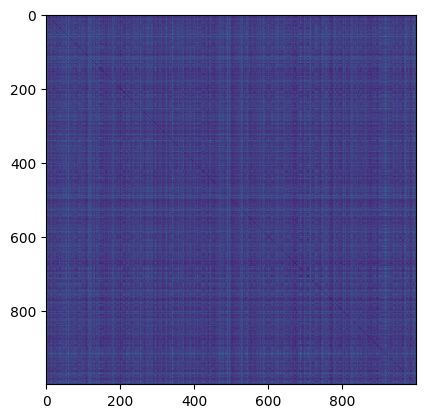

In [54]:
## Circle translation test :: Compute Wasserstein square distance matrix usinng this
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance_trans)

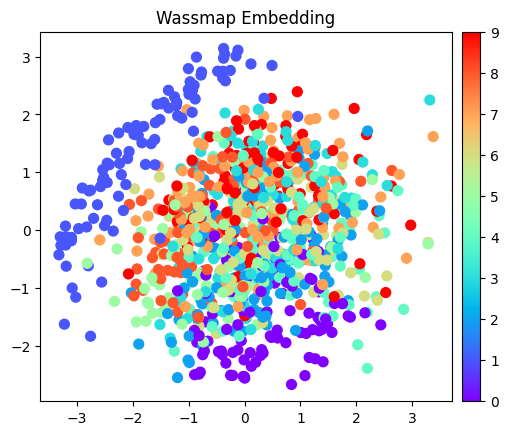

In [56]:
WassEmbedding_trans = MDS(Wass_distance_trans, squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:, 0]
scatter_y = WassEmbedding_trans[:, 1]
sc = ax1.scatter(scatter_x, scatter_y, c=y_subset, cmap='rainbow', s=50)
ax1.set_title('Wassmap Embedding')
plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [57]:
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [58]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
WassEmbedding_mds = mds.fit_transform(Wass_distance_trans)

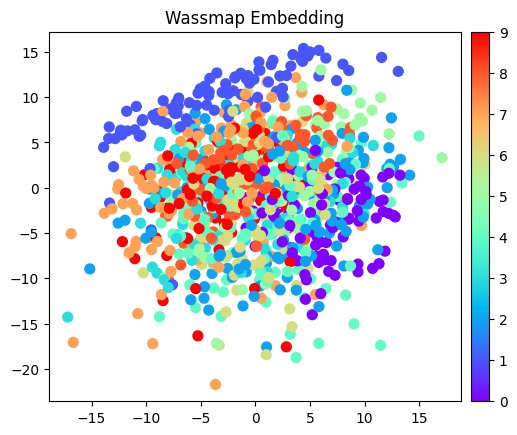

In [59]:
# Plotting the embedding
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_mds[:, 0]
scatter_y = WassEmbedding_mds[:, 1]
sc = ax1.scatter(scatter_x, scatter_y,  c=y_subset, cmap='rainbow', s=50)
ax1.set_title('Wassmap Embedding')
plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [60]:
isomap = Isomap(n_components=2, metric='precomputed')
# Note: Isomap typically expects a nearest neighbors graph. We'll approximate its behavior.
Wass_distance_graph = kneighbors_graph(Wass_distance_trans, n_neighbors=6, include_self=True, mode='distance')
WassEmbedding_isomap = isomap.fit_transform(Wass_distance_graph)

In [61]:
tsne = TSNE(n_components=2, metric ='precomputed',init = 'random',random_state=42, perplexity=50)
WassEmbedding_tsne = tsne.fit_transform(Wass_distance_trans)

In [62]:
tsne = TSNE(n_components=2,random_state=42)
WassEmbedding_tsne = tsne.fit_transform(Wass_distance_trans)

In [63]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42) #n_neighbors=10)
WassEmbedding_lle = lle.fit_transform(Wass_distance_trans)

In [64]:
similarity_matrix = np.exp(-Wass_distance_trans ** 2 / (4. * np.std(Wass_distance_trans) ** 2))
spectral = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
WassEmbedding_spectral = spectral.fit_transform(similarity_matrix)

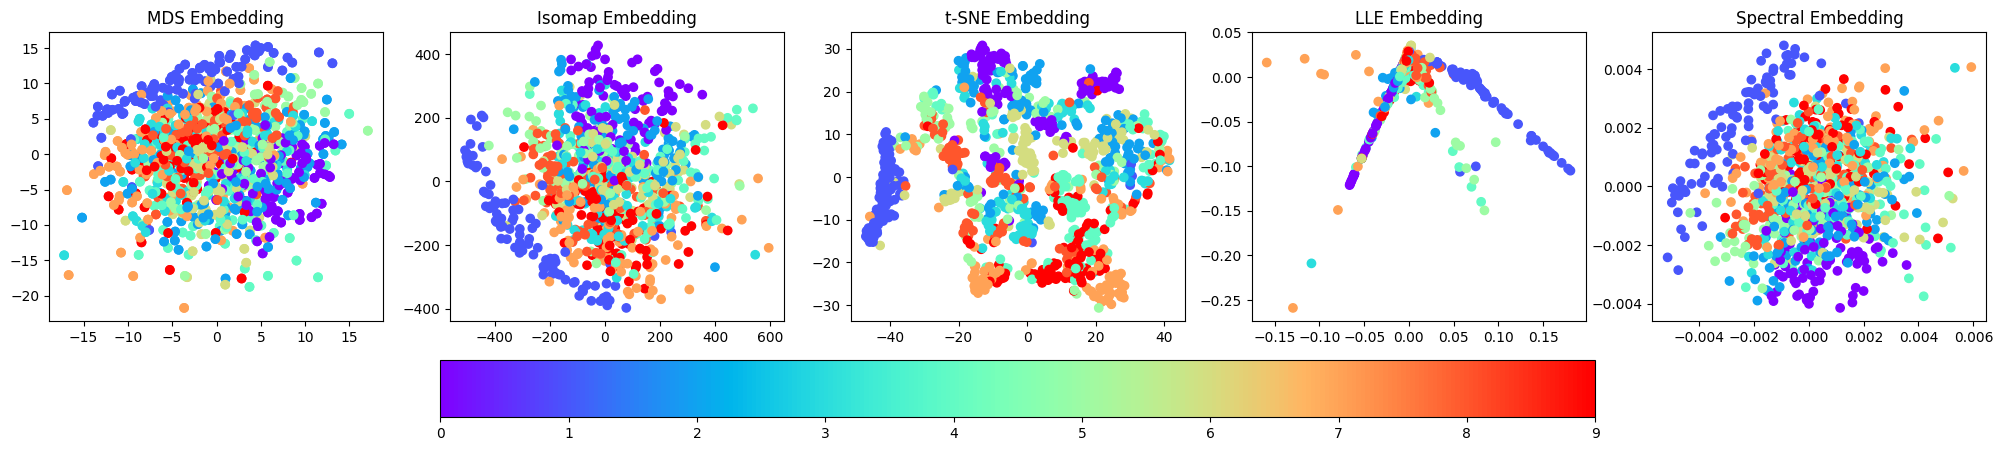

In [65]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# MDS
axs[0].scatter(WassEmbedding_mds[:, 0], WassEmbedding_mds[:, 1], c=y_subset, cmap='rainbow')
axs[0].set_title('MDS Embedding')

# Isomap
axs[1].scatter(WassEmbedding_isomap[:, 0], WassEmbedding_isomap[:, 1], c=y_subset, cmap='rainbow')
axs[1].set_title('Isomap Embedding')

# t-SNE
axs[2].scatter(WassEmbedding_tsne[:, 0], WassEmbedding_tsne[:, 1], c=y_subset, cmap='rainbow')
axs[2].set_title('t-SNE Embedding')

# LLE
axs[3].scatter(WassEmbedding_lle[:, 0], WassEmbedding_lle[:, 1], c=y_subset, cmap='rainbow')
axs[3].set_title('LLE Embedding')

# Spectral
axs[4].scatter(WassEmbedding_spectral[:, 0], WassEmbedding_spectral[:, 1], c=y_subset, cmap='rainbow')
axs[4].set_title('Spectral Embedding')

plt.colorbar(axs[0].scatter(WassEmbedding_mds[:, 0], WassEmbedding_mds[:, 1],c=y_subset, cmap='rainbow'), ax=axs, orientation='horizontal', pad=0.1)
plt.show()


# Classification Task

In [66]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

In [67]:
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN (K=1)': KNeighborsClassifier(n_neighbors=1),
    'KNN (K=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM Linear': SVC(kernel='linear'),
    'SVM RBF': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000) 
}

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)

In [69]:
no_embedding_accuracies = {}

for name, clf in classifiers.items():
    clf.fit(X_subset, y_subset)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    no_embedding_accuracies[name] = accuracy
    #print(f"{name} - No Embedding: Accuracy = {accuracy*100:.2f}%")

In [70]:
no_embedding_mean_std = {
    name: f"{np.mean(accs):.2f} ± {np.std(accs):.2f}"
    for name, accs in no_embedding_accuracies.items()}

no_embedding_df = pd.DataFrame([no_embedding_mean_std], index=['No Embedding'])
no_embedding_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,1.00 ± 0.00,1.00 ± 0.00,0.92 ± 0.00,0.90 ± 0.00,1.00 ± 0.00,0.98 ± 0.00,1.00 ± 0.00,1.00 ± 0.00


In [71]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=10, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

mds_accuracy_results = {name: [] for name in classifiers.keys()}
for (metric_value, eps), train_transformed in embeddings.items():
    X_train_transformed, X_test_transformed, y_train_subset, y_test_subset = train_test_split(
        train_transformed, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_transformed, y_train_subset)
        y_pred = clf.predict(X_test_transformed)
        accuracy = accuracy_score(y_test_subset, y_pred)
        mds_accuracy_results[name].append(accuracy)
       # print(f"{name} - MDS (metric={metric_value}, eps={eps}): Accuracy = {accuracy*100:.2f}%")

mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df_10 = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df_10

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.72 ± 0.02,0.63 ± 0.01,0.66 ± 0.01,0.68 ± 0.01,0.72 ± 0.02,0.75 ± 0.01,0.70 ± 0.02,0.72 ± 0.01


In [72]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [10]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split)
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)
        isomap_accuracy_results[name].append(accuracy)
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy*100:.2f}%")

isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df_10 = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df_10

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.84 ± 0.00,0.85 ± 0.01,0.85 ± 0.01,0.87 ± 0.00,0.85 ± 0.01,0.88 ± 0.00,0.85 ± 0.01,0.86 ± 0.01


In [73]:
n_perplexity_values = [ 3, 5, 7]
n_components_values = [2, 3]

transformed_tsne_data_list = []
for perplexity_val in n_perplexity_values:
    for i, n_components_val in enumerate(n_components_values):
        tsne = TSNE(n_components=n_components_val, perplexity=perplexity_val, random_state=42)
        transformed_tsne_data = tsne.fit_transform(Wass_distance_trans)
        transformed_tsne_data_list.append((perplexity_val, n_components_val, transformed_tsne_data))

tsne_accuracy_results = {name: [] for name in classifiers.keys()}

for perplexity_val, n_components_val, transformed_data in transformed_tsne_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split) 
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)  
        tsne_accuracy_results[name].append(accuracy)  

tsne_mean_std_accuracy_results = {}
for name, acc_list in tsne_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    tsne_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

tsne_df = pd.DataFrame([tsne_mean_std_accuracy_results], index=['t-SNE'])
tsne_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
t-SNE,0.44 ± 0.07,0.69 ± 0.01,0.68 ± 0.01,0.66 ± 0.01,0.47 ± 0.09,0.60 ± 0.05,0.71 ± 0.01,0.44 ± 0.08


In [74]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [10]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     
lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split) 
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)  
        lle_accuracy_results[name].append(accuracy)

lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df_10 = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df_10

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.49 ± 0.09,0.60 ± 0.04,0.62 ± 0.03,0.64 ± 0.01,0.14 ± 0.00,0.59 ± 0.04,0.65 ± 0.04,0.33 ± 0.10


In [75]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [10]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split)
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)
        spectral_accuracy_results[name].append(accuracy)

spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"
    
spectral_df_10 = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df_10

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.58 ± 0.09,0.59 ± 0.04,0.61 ± 0.02,0.64 ± 0.02,0.14 ± 0.00,0.64 ± 0.05,0.64 ± 0.02,0.23 ± 0.03


In [76]:
combined_df = pd.concat([no_embedding_df, mds_df_10, isomap_df_10, tsne_df, lle_df_10, spectral_df_10])
combined_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,1.00 ± 0.00,1.00 ± 0.00,0.92 ± 0.00,0.90 ± 0.00,1.00 ± 0.00,0.98 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
MDS,0.72 ± 0.02,0.63 ± 0.01,0.66 ± 0.01,0.68 ± 0.01,0.72 ± 0.02,0.75 ± 0.01,0.70 ± 0.02,0.72 ± 0.01
Isomap,0.84 ± 0.00,0.85 ± 0.01,0.85 ± 0.01,0.87 ± 0.00,0.85 ± 0.01,0.88 ± 0.00,0.85 ± 0.01,0.86 ± 0.01
t-SNE,0.44 ± 0.07,0.69 ± 0.01,0.68 ± 0.01,0.66 ± 0.01,0.47 ± 0.09,0.60 ± 0.05,0.71 ± 0.01,0.44 ± 0.08
LLE,0.49 ± 0.09,0.60 ± 0.04,0.62 ± 0.03,0.64 ± 0.01,0.14 ± 0.00,0.59 ± 0.04,0.65 ± 0.04,0.33 ± 0.10
Spectral Embedding,0.58 ± 0.09,0.59 ± 0.04,0.61 ± 0.02,0.64 ± 0.02,0.14 ± 0.00,0.64 ± 0.05,0.64 ± 0.02,0.23 ± 0.03


In [77]:
from scipy.stats import ttest_ind
techniques_10 = combined_df.index.tolist()
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_10 = {}
for technique in techniques_10:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_10[technique] = p_value

print("One-Sided T-Test Results for 10 Components:")
for technique, p_value in ttest_results_10.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 10 Components:
MDS: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
t-SNE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0001
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0001
  Significant difference at p < 0.05, reject H0


# 100 Components

In [78]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=100, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

mds_accuracy_results = {name: [] for name in classifiers.keys()}
for (metric_value, eps), train_transformed in embeddings.items():
    X_train_transformed, X_test_transformed, y_train_subset, y_test_subset = train_test_split(
        train_transformed, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_transformed, y_train_subset)
        y_pred = clf.predict(X_test_transformed)
        accuracy = accuracy_score(y_test_subset, y_pred)
        mds_accuracy_results[name].append(accuracy)
       # print(f"{name} - MDS (metric={metric_value}, eps={eps}): Accuracy = {accuracy*100:.2f}%")

mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df_100 = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.76 ± 0.02,0.63 ± 0.02,0.67 ± 0.01,0.70 ± 0.00,0.78 ± 0.00,0.76 ± 0.00,0.72 ± 0.01,0.75 ± 0.02


In [89]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [100]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split)
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)
        isomap_accuracy_results[name].append(accuracy)
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy*100:.2f}%")

isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df_100 = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.88 ± 0.02,0.84 ± 0.01,0.84 ± 0.01,0.85 ± 0.01,0.88 ± 0.01,0.92 ± 0.01,0.87 ± 0.01,0.89 ± 0.01


In [82]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [100]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     
lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split) 
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)  
        lle_accuracy_results[name].append(accuracy)

lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df_100 = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.72 ± 0.04,0.68 ± 0.02,0.68 ± 0.02,0.69 ± 0.03,0.34 ± 0.01,0.72 ± 0.04,0.72 ± 0.03,0.65 ± 0.04


In [86]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [100]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(transformed_data, y_subset, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train_split, y_train_split)
        y_pred = clf.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_pred)
        spectral_accuracy_results[name].append(accuracy)

spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"
    
spectral_df_100 = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.71 ± 0.01,0.62 ± 0.04,0.65 ± 0.02,0.68 ± 0.01,0.14 ± 0.00,0.69 ± 0.01,0.70 ± 0.02,0.32 ± 0.10


In [90]:
combined_df_100 = pd.concat([no_embedding_df, mds_df_100, isomap_df_100, tsne_df, lle_df_100, spectral_df_100])
combined_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,1.00 ± 0.00,1.00 ± 0.00,0.92 ± 0.00,0.90 ± 0.00,1.00 ± 0.00,0.98 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
MDS,0.76 ± 0.02,0.63 ± 0.02,0.67 ± 0.01,0.70 ± 0.00,0.78 ± 0.00,0.76 ± 0.00,0.72 ± 0.01,0.75 ± 0.02
Isomap,0.88 ± 0.02,0.84 ± 0.01,0.84 ± 0.01,0.85 ± 0.01,0.88 ± 0.01,0.92 ± 0.01,0.87 ± 0.01,0.89 ± 0.01
t-SNE,0.44 ± 0.07,0.69 ± 0.01,0.68 ± 0.01,0.66 ± 0.01,0.47 ± 0.09,0.60 ± 0.05,0.71 ± 0.01,0.44 ± 0.08
LLE,0.72 ± 0.04,0.68 ± 0.02,0.68 ± 0.02,0.69 ± 0.03,0.34 ± 0.01,0.72 ± 0.04,0.72 ± 0.03,0.65 ± 0.04
Spectral Embedding,0.71 ± 0.01,0.62 ± 0.04,0.65 ± 0.02,0.68 ± 0.01,0.14 ± 0.00,0.69 ± 0.01,0.70 ± 0.02,0.32 ± 0.10


In [91]:
from scipy.stats import ttest_ind
techniques_100 = combined_df_100.index.tolist()
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_100 = {}
for technique in techniques_100:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df_100.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df_100.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_100[technique] = p_value

print("One-Sided T-Test Results for 100 Components:")
for technique, p_value in ttest_results_100.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 100 Components:
MDS: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
t-SNE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0001
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0004
  Significant difference at p < 0.05, reject H0
